# <font color="#000099">llm-d-benchmarking PD vs Aggregate Configuration Sweep Analysis</font>

This notebook imports benchmark report data from configuration sweeps from [llm-d-benchmark](https://github.com/llm-d/llm-d-benchmark), and creates Pareto plots to compare configurations for a particular model and workload.

The first cell contains function and class definitions to support basic functionality, while the second cell imports data from user-provided directories into [Pandas](https://pandas.pydata.org/) [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

The cells following will look at the different scenarios (a particular selection of model, GPU, and workload input/output size) and create tables and Pareto plots for different configurations under these scenarios.

While this basic functionality may be sufficient for many purposes, this notebook should be considered a starting point for more detailed analysis and customization by the user.

## Package imports and definitions (run once)

In [1]:
################################################################################
# Package imports
################################################################################

import os
import sys
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas

#sys.path.insert(0, '../workload/report/')
import convert
import schema


class Text:
    """ANSI SGR control codes for text formatting"""
    DEFAULT = "\x1b[0m"
    BOLD = "\x1b[1m"
    BOLD_OFF = "\x1b[22m"
    UNDERLINE = "\x1b[4m"
    UNDERLINE_OFF = "\x1b[24m"
    DEFAULT_COLOR = "\x1b[39m"
    DEFAULT_BG_COLOR = "\x1b[49m"
    RED = "\x1b[31m"
    YELLOW = "\x1b[33m"
    GREEN = "\x1b[32m"
    CYAN = "\x1b[36m"
    BLUE = "\x1b[34m"
    MAGENTA = "\x1b[35m"
    BLACK = "\x1b[30m"
    WHITE = "\x1b[37m"
    BG_RED = "\x1b[41m"
    BG_YELLOW = "\x1b[43m"
    BG_GREEN = "\x1b[42m"
    BG_CYAN = "\x1b[46m"
    BG_BLUE = "\x1b[44m"
    BG_MAGENTA = "\x1b[45m"
    BG_BLACK = "\x1b[40m"
    BG_WHITE = "\x1b[47m"


def info(mesg: str) -> None:
    """Print information message.

    Args:
        mesg (str): Information message.
    """
    sys.stderr.write(f'{Text.GREEN}{mesg}\n{Text.DEFAULT}')


def warn(mesg: str) -> None:
    """Print a warning message.

    Args:
        mesg (str): Warming message.
    """
    sys.stderr.write(f'{Text.YELLOW}{mesg}\n{Text.DEFAULT}')


def error(mesg: str, err_code: int = 1) -> None:
    """Print an error message and exit with an error code.

    Args:
        mesg (str): Error message.
        err_code (int): Error code.
    """
    sys.stderr.write(f'{Text.RED}{mesg}\n{Text.DEFAULT}')
    sys.exit(err_code)


def check_dir(dir: str) -> None:
    """Print an error if directory does not exist.

    Args:
        dir (str): Directory to check existence of.
    """
    if not os.path.isdir(dir):
        error(f'Invalid path: {dir}')


def check_file(file: str) -> None:
    """Print an error if file does not exist.

    Args:
        file (str): File to check existence of.
    """
    if not os.path.isfile(file):
        error(f'Invalid file: {file}')


def get_benchmark_report_files(source_dir: str) -> list[str]:
    """Get a list of benchmark report files within provided path (recursive).

    Args:
        source_dir (str): Directory to recursively search for results files.
    
    Returns:
        list: List of paths to benchmark report files.
    """
    rb_files = []
    check_dir(source_dir)
    path = Path(source_dir)
    for file in path.rglob("benchmark_report,_*.yaml"):
        rb_files.append(str(file))
    return rb_files


def make_benchmark_runs_df() -> pandas.core.frame.DataFrame:
    """Create DataFrame for benchmark run results.

    Returns:
        DataFrame: Empty DataFrame for benchmark runs.
    """
    return pandas.DataFrame(columns=[
        'Name',
        'Directory',
        'Model',
        'GPU',
        'DP',
        'TP',
        'PP',
        'EP',
        'Replicas',
        'P_DP',
        'P_TP',
        'P_PP',
        'P_EP',
        'P_Replicas',
        'D_DP',
        'D_TP',
        'D_PP',
        'D_EP',
        'D_Replicas',
        'Concurrency',
        'ISL',
        'OSL',
        'Backend',
        'Duration',
        'Completed',
        'Request_Throughput',
        'Output_Token_Throughput',
        'Total_Token_Throughput',
        'Mean_TTFT_ms',
        'Mean_TPOT_ms',
        'Mean_ITL_ms',
        'Mean_E2EL_ms',
        'Is_PD',
        'Num_GPUs',
        'Thpt_per_GPU',
        'Thpt_per_User',
    ])


def _get_replicas_and_parallelism(report: schema.BenchmarkReport) -> dict[str, int | None]:
    """Get the number of replicas and parallelisms.

    Args:
        report (BenchmarkReport): Benchmark run to evaluate.

    Returns:
        dict[str, int | None]: Replicas and parallelisms for standalone or
            prefill/decode configuration. Irrelevant fields will have a value
            of None.
    """
    rp = {}
    rp['replicas'] = report.scenario.host.type.count(schema.HostType.REPLICA)
    rp['p_replicas'] = report.scenario.host.type.count(schema.HostType.PREFILL)
    rp['d_replicas'] = report.scenario.host.type.count(schema.HostType.DECODE)
    if rp['replicas'] == 0:
        rp['replicas'] = None
    if rp['p_replicas'] == 0:
        rp['p_replicas'] = None
    if rp['d_replicas'] == 0:
        rp['d_replicas'] = None
    rp['tp'] = None
    rp['dp'] = None
    rp['pp'] = None
    rp['ep'] = None
    rp['p_tp'] = None
    rp['p_dp'] = None
    rp['p_pp'] = None
    rp['p_ep'] = None
    rp['d_tp'] = None
    rp['d_dp'] = None
    rp['d_pp'] = None
    rp['d_ep'] = None
    if rp['replicas']:
        # We have a standalone setup
        rp['is_pd'] = False
        rp['tp'] = report.scenario.host.accelerator[0].parallelism.tp
        rp['dp'] = report.scenario.host.accelerator[0].parallelism.dp
        rp['pp'] = report.scenario.host.accelerator[0].parallelism.pp
        rp['ep'] = report.scenario.host.accelerator[0].parallelism.ep
        return rp
    # We have a P/D setup
    rp['is_pd'] = True
    for ii, accel in enumerate(report.scenario.host.accelerator):
        if report.scenario.host.type[ii] is schema.HostType.PREFILL and not rp['p_tp']:
            rp['p_tp'] = accel.parallelism.tp
            rp['p_dp'] = accel.parallelism.dp
            rp['p_pp'] = accel.parallelism.pp
            rp['p_ep'] = accel.parallelism.ep
        if report.scenario.host.type[ii] is schema.HostType.DECODE and not rp['d_tp']:
            rp['d_tp'] = accel.parallelism.tp
            rp['d_dp'] = accel.parallelism.dp
            rp['d_pp'] = accel.parallelism.pp
            rp['d_ep'] = accel.parallelism.ep
        if rp['p_tp'] and rp['d_tp']:
            break
    return rp


def _make_name(report: schema.BenchmarkReport) -> str:
    """Create a name based on the benchmark run's configuration.

    Args:
        report (BenchmarkReport): Benchmark report to create a name for.

    Returns:
        str: Name of benchmark run, providing replica and parallelism details.
    """
    rp = _get_replicas_and_parallelism(report)
    if rp['replicas']:
        # We have a standalone setup
        return f'{rp['replicas']}R TP{rp['tp']}'
    # We have a P/D setup
    # TODO we currently assume the only type of parallelism is TP
    return f'{rp['p_replicas']}P TP{rp['p_tp']}, {rp['d_replicas']}D TP{rp['d_tp']}'


def add_benchmark_report_to_df(
    runs_df: pandas.core.frame.DataFrame,
    br_file: str) -> None:
    """Load a results file and add it to the DataFrame of benchmark runs.

    Args:
        runs_df (DataFrame): DataFrame to add a row to for the provided run.
        br_file (str): Benchmark report file to import.
    """
    report = convert.import_benchmark_report(br_file)
    rp = _get_replicas_and_parallelism(report)

    # TODO getting concurrency is speciffic to each harness, will need
    # a way to capture this universally in the report so we don't have to do
    # extractions like this
    if report.scenario.load.args and 'max_concurrency' in report.scenario.load.args:
        # vLLM Benchmark
        concurrency = report.scenario.load.args['max_concurrency']
    elif report.scenario.load.args and 'profile' in report.scenario.load.args \
    and 'measured_concurrencies' in report.scenario.load.args['profile']:
        # GuideLLM
        concurrency = report.scenario.load.args['profile']['measured_concurrencies'][0]
    else:
        warn('"Concurrency" is not defined, setting to 1, "Thpt_per_User" and Pareto plots will also be invalid.')
        concurrency = 1

    # Calculated columns
    if rp['is_pd']:
        num_gpus = rp['p_tp']*rp['p_replicas'] + rp['d_tp']*rp['d_replicas']
    else:
        num_gpus = rp['tp']*rp['replicas']
    thpt_per_gpu = report.metrics.throughput.output_tokens_per_sec/num_gpus
    thpt_per_user = report.metrics.throughput.output_tokens_per_sec/concurrency

    # Add row to DataFrame
    runs_df.loc[len(runs_df)] = {
        'Name': _make_name(report),
        # We want the base directory for the sweep, which is two levels up
        'Directory': os.path.abspath(br_file).rsplit(os.sep, 2)[0],
        'Model': report.scenario.model.name,
        # Assume heterogeneous across P and D
        'GPU': report.scenario.host.accelerator[0].model,
        'DP': rp['dp'],
        'TP': rp['tp'],
        'PP': rp['pp'],
        'EP': rp['ep'],
        'Replicas': rp['replicas'],
        'P_DP': rp['p_dp'],
        'P_TP': rp['p_tp'],
        'P_PP': rp['p_pp'],
        'P_EP': rp['p_ep'],
        'P_Replicas': rp['p_replicas'],
        'D_DP': rp['d_dp'],
        'D_TP': rp['d_tp'],
        'D_PP': rp['d_pp'],
        'D_EP': rp['d_ep'],
        'D_Replicas': rp['d_replicas'],
        'Concurrency': concurrency,
        # TODO this may need to be configurable...
        # We need to group by ISL/OSL exactly, so round and convert to int.
        # Round ISL to nearest 100's
        'ISL': int(round(report.metrics.requests.input_length.mean, -2)),
        'OSL': int(round(report.metrics.requests.output_length.mean, -2)),
        'Duration': report.metrics.time.duration,
        'Completed': report.metrics.requests.total,
        'Request_Throughput': report.metrics.throughput.requests_per_sec,
        'Output_Token_Throughput': report.metrics.throughput.output_tokens_per_sec,
        'Total_Token_Throughput': report.metrics.throughput.total_tokens_per_sec,
        'Mean_TTFT_ms': report.metrics.latency.time_to_first_token.mean * (1000 if report.metrics.latency.time_to_first_token.units == schema.Units.S else 1),
        'Mean_TPOT_ms': report.metrics.latency.time_per_output_token.mean * (1000 if report.metrics.latency.time_per_output_token.units == schema.Units.S_PER_TOKEN else 1),
        'Mean_ITL_ms': report.metrics.latency.inter_token_latency.mean * (1000 if report.metrics.latency.inter_token_latency.units == schema.Units.S_PER_TOKEN else 1),
        'Mean_E2EL_ms': report.metrics.latency.request_latency.mean * (1000 if report.metrics.latency.request_latency.units == schema.Units.S else 1),
        'Is_PD': rp['is_pd'],
        'Num_GPUs': num_gpus,
        'Thpt_per_GPU': thpt_per_gpu,
        'Thpt_per_User': thpt_per_user,
    }


def get_scenarios(runs_df: pandas.core.frame.DataFrame) -> list[tuple[str]]:
    """Get a list of available scenarios from runs DataFrame, where
    configurations and concurrency will be swept.

    Args:
        runs_df (DataFrame): Benchmark runs to find the scenarios for.

    Returns:
        list[tuple[str]]: List of scenarios, consisting of unique groups of
            model, GPU type, ISL, and OSL.
    """
    columns = ['Model', 'GPU', 'ISL', 'OSL']
    return list(set(runs_df.set_index(columns).index))


def print_scenarios(scenarios: list[tuple[str]]) -> None:
    """Print a formatted table of scenarios.

    Args:
        scenarios (list[tuple[str]]): Scenario groups to print.
    """
    columns = ['Model', 'GPU', 'ISL', 'OSL']
    # Get maximum text length for each column, including header
    spans = list(map(len, columns))
    for sc in scenarios:
        for jj, item in enumerate(sc):
            if spans[jj] < len(str(item)):
                spans[jj] = len(str(item))

    # Create header, starting with scenario index
    header = f'{Text.BOLD}{Text.BLUE}IDX  {Text.DEFAULT}{Text.BOLD}'
    # Add each column name to header
    for ii, col in enumerate(columns):
        header += col + " " * (spans[ii] - len(col) + 2)
    header += f'{Text.DEFAULT}'
    print(header)

    # Print details of each scenario
    for ii, sc in enumerate(scenarios):
        row = f'{Text.BLUE}{ii}{Text.DEFAULT}' + " " * (5 - len(str(ii)))
        for jj, val in enumerate(sc):
            row += f'{str(val)}' + " " * (spans[jj] - len(str(val)) + 2)
        print(row)

## Import datasets

In [ ]:
################################################################################
# User inputs
################################################################################

# List of directories containing benchmark sweeps to import.
search_dirs = [
    "/path/to/data",
]

################################################################################
# Standard code
################################################################################

# Create blank DataFrames for benchmarking runs
runs = make_benchmark_runs_df()

# Populate the runs DataFrame
for sdir in search_dirs:
    info(f'Searching for benchmark report files within {sdir}')
    # Find all benchmark report files in the directory
    for br_file in get_benchmark_report_files(sdir):
        #info(f'Importing {br_file}')
        # Import the results and add to the runs DataFrame
        add_benchmark_report_to_df(runs, br_file)

## Scenarios available

In [16]:
# Scenarios available, where model, GPU type, ISL and OSL are constant.
# Configurations (seplicas and parallelism) are swept within a scenario.

scenarios = get_scenarios(runs)
print_scenarios(scenarios)

IDX  Model                              GPU                    ISL    OSL   
0    meta-llama/Llama-3.1-70B-Instruct  NVIDIA-H100-80GB-HBM3  10000  1000  


## Configuration plots and tables

/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_modelservice_NA_NA_1_8_1_8/results


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
17,4,1,4,3,1,55.516815,3.469801,55.516815
16,4,1,4,3,8,379.175346,23.698459,47.396918
13,4,1,4,3,32,1083.040525,67.690033,33.845016
14,4,1,4,3,64,1695.893706,105.993357,26.498339
15,4,1,4,3,128,2207.080054,137.942503,17.242813
12,4,1,4,3,256,2426.687658,151.667979,9.479249


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_modelservice_NA_NA_1_8_1_8/results


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
1,8,1,8,1,1,80.077194,5.004825,80.077194
5,8,1,8,1,8,478.644446,29.915278,59.830556
3,8,1,8,1,32,1221.759783,76.359986,38.179993
2,8,1,8,1,64,1905.659310,119.103707,29.775927
0,8,1,8,1,128,2380.756187,148.797262,18.599658
4,8,1,8,1,256,2439.438699,152.464919,9.529057


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_modelservice_NA_NA_1_8_1_8/results


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
7,4,2,8,1,1,61.301267,3.831329,61.301267
8,4,2,8,1,8,393.398841,24.587428,49.174855
6,4,2,8,1,32,973.096233,60.818515,30.409257
9,4,2,8,1,64,1722.700624,107.668789,26.917197
10,4,2,8,1,128,2077.971165,129.873198,16.234150
11,4,2,8,1,256,2294.815492,143.425968,8.964123


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_modelservice_NA_NA_1_8_1_8/results


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
21,4,2,4,2,1,55.502382,3.468899,55.502382
18,4,2,4,2,8,363.395526,22.712220,45.424441
19,4,2,4,2,32,1073.150417,67.071901,33.535951
20,4,2,4,2,64,1772.041383,110.752586,27.688147
22,4,2,4,2,128,2203.129022,137.695564,17.211945
23,4,2,4,2,256,2430.418964,151.901185,9.493824


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_modelservice_NA_NA_1_8_1_8/results


,P_TP,P_Replicas,D_TP,D_Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
25,4,3,4,1,1,55.241165,3.452573,55.241165
29,4,3,4,1,8,365.517937,22.844871,45.689742
27,4,3,4,1,32,977.883575,61.117723,30.558862
26,4,3,4,1,64,1780.353201,111.272075,27.818019
28,4,3,4,1,128,2208.275000,138.017187,17.252148
24,4,3,4,1,256,2420.213017,151.263314,9.453957


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_standalone_2_8_NA_NA_NA_NA/results


,TP,Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
30,8,2,1,37.965470,2.372842,37.965470
31,8,2,8,247.605666,15.475354,30.950708
32,8,2,32,770.881073,48.180067,24.090034
33,8,2,64,1128.919094,70.557443,17.639361
34,8,2,128,1620.236227,101.264764,12.658096
35,8,2,256,1787.688976,111.730561,6.983160


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_standalone_2_8_NA_NA_NA_NA/results


,TP,Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
36,4,4,1,48.146594,3.009162,48.146594
40,4,4,8,344.100688,21.506293,43.012586
39,4,4,32,1013.391458,63.336966,31.668483
37,4,4,64,1566.935884,97.933493,24.483373
38,4,4,128,2231.207904,139.450494,17.431312
41,4,4,256,2567.929772,160.495611,10.030976


/files/Projects/Hybrid_Cloud/llm-d/Benchmarking/well-lit_runs/Sanitized/PD Disaggregation/pd-disaggregation.setup_standalone_2_8_NA_NA_NA_NA/results


,TP,Replicas,Concurrency,Output_Token_Throughput,Thpt_per_GPU,Thpt_per_User
46,2,8,1,33.581498,2.098844,33.581498
45,2,8,8,251.989226,15.749327,31.498653
47,2,8,32,585.226248,36.576640,18.288320
42,2,8,64,609.225885,38.076618,9.519154
44,2,8,128,616.267555,38.516722,4.814590
43,2,8,256,623.218098,38.951131,2.434446


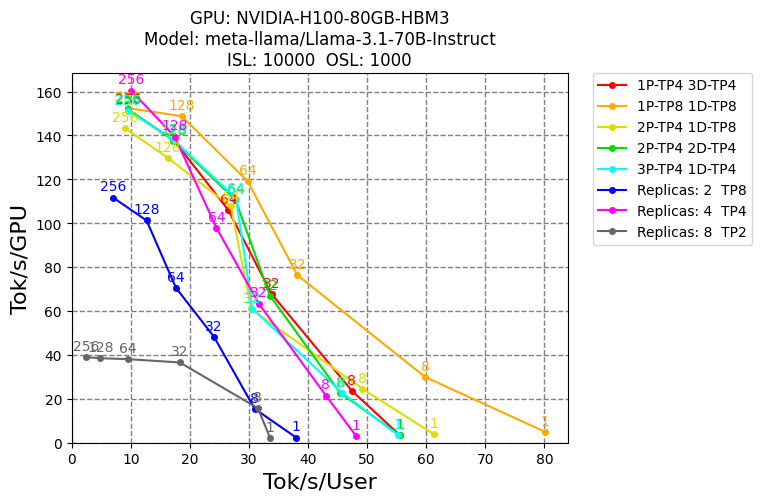

In [17]:
################################################################################
# User inputs
################################################################################

# Select scenario
idx = 0

# Show P/D disaggregated scenarios
show_pd = True
# Show standalone scenarios
show_sa = True

# Segregate traces by directory (directories with identical scenarios, such as
# repeated runs, will not be joined together in a single trace)
seg_by_dir = True

################################################################################
# Standard code
################################################################################

# Get parameters of selected scenario
model, gpu, isl, osl = scenarios[idx]

# Filter on column values
pd_runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Is_PD'] == True) ][[
    'Model',
    'GPU',
    'P_TP',
    'P_Replicas',
    'D_TP',
    'D_Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Output_Token_Throughput',
    'Thpt_per_GPU',
    'Thpt_per_User',
    'Directory']].drop('Model', axis=1).drop('GPU', axis=1).drop('ISL', axis=1).drop('OSL', axis=1)#.sort_values(by='Output_Token_Throughput')

sa_runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Is_PD'] == False) ][[
    'Model',
    'GPU',
    'TP',
    'Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Output_Token_Throughput',
    'Thpt_per_GPU',
    'Thpt_per_User',
    'Directory']].drop('Model', axis=1).drop('GPU', axis=1).drop('ISL', axis=1).drop('OSL', axis=1)#.sort_values(by='Output_Token_Throughput')

# Plot performance results
colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000',
         '#990000', '#777700', '#007700', '#009999', '#000099']

# Unique configurations of replicas and TP, described as a tuple
# Tuple format is (rep, tp, p_rep, p_tp, d_rep, d_tp, dir, is_pd)
config_sets = []
if seg_by_dir:
    configs_pd = list(set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP', 'Directory']).index))
    configs_sa = list(set(sa_runs_selected.set_index(['Replicas', 'TP', 'Directory']).index))
    if show_pd:
        for conf in configs_pd:
            config_sets.append((
                0,       # Replicas
                0,       # TP
                conf[0], # P replicas
                conf[1], # P TP
                conf[2], # D replicas
                conf[3], # D TP
                conf[4], # Directory
                True,    # Is PD
            ))
    if show_sa:
        for conf in configs_sa:
            config_sets.append((
                conf[0], # Replicas
                conf[1], # TP
                0,       # P replicas
                0,       # P TP
                0,       # D replicas
                0,       # D TP
                conf[2], # Directory
                False    # Is PD
            ))
else:
    pd_runs_selected = pd_runs_selected.drop('Directory', axis=1)
    sa_runs_selected = sa_runs_selected.drop('Directory', axis=1)
    configs_pd = list(set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']).index))
    configs_sa = list(set(sa_runs_selected.set_index(['Replicas', 'TP']).index))
    if show_pd:
        for conf in configs_pd:
            config_sets.append((
                0,       # Replicas
                0,       # TP
                conf[0], # P replicas
                conf[1], # P TP
                conf[2], # D replicas
                conf[3], # D TP
                0,       # Directory
                True,    # Is PD
            ))
    if show_sa:
        for conf in configs_sa:
            config_sets.append((
                conf[0], # Replicas
                conf[1], # TP
                0,       # P replicas
                0,       # P TP
                0,       # D replicas
                0,       # D TP
                0,       # Directory
                False    # Is PD
            ))

# Sort so prinouts/plots are organized
config_sets.sort()

# Convert the list of sets to a list of dicts, to make code following clearer
configs = []
for conf in config_sets:
    configs.append({
        'rep': conf[0],
        'tp': conf[1],
        'p_rep': conf[2],
        'p_tp': conf[3],
        'd_rep': conf[4],
        'd_tp': conf[5],
        'dir': conf[6],
        'is_pd': conf[7],
    })

if not configs:
    if show_pd:
        print('No P/D configurations for this scenario!')
    if show_sa:
        print('No standalone configurations for this scenario!')

# Sweep through configurations
for ii, conf in enumerate(configs):
    is_pd = 'P_TP' in conf
    # Make a DataFrame for specific configuration
    if conf['is_pd']:
        # This configuration is PD
        if seg_by_dir:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp']) &
                (pd_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')

            print(pd_runs_selected.iloc[0]['Directory'])
        else:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp'])
            ].sort_values(by='Concurrency')

        
        # Print table
        display(conf_df)
    
        # Plot throughputs for configuration
        plt.plot(conf_df.Thpt_per_User, conf_df.Thpt_per_GPU,
                 label=f'{conf['p_rep']}P-TP{conf['p_tp']} {conf['d_rep']}D-TP{conf['d_tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Thpt_per_User)[jj],
                     list(conf_df.Thpt_per_GPU)[jj]+pd_runs_selected['Thpt_per_GPU'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    else:
        # This configuration is standalone
        if seg_by_dir:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp']) &
                (sa_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')

            print(sa_runs_selected.iloc[0]['Directory'])
        else:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp'])
            ].sort_values(by='Concurrency')

        # Print table
        display(conf_df)
    
        # Plot throughputs for configuration
        plt.plot(conf_df.Thpt_per_User, conf_df.Thpt_per_GPU,
                 label=f'Replicas: {conf['rep']}  TP{conf['tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Thpt_per_User)[jj],
                     list(conf_df.Thpt_per_GPU)[jj]+sa_runs_selected['Thpt_per_GPU'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])

if configs:
    plt.title(f'GPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
    plt.xlabel('Tok/s/User', fontsize='16')
    plt.ylabel('Tok/s/GPU', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, None, 0, None])
    plt.show()


### Pareto front

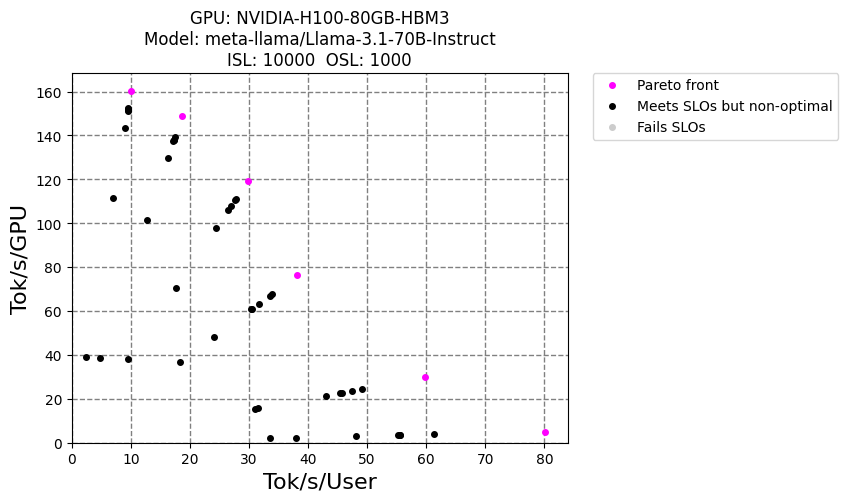

In [18]:
import numpy as np

ttft_max = np.inf
tpot_max = np.inf
thpt_min = 0

################################################################################
# User inputs
################################################################################

# Select scenario
idx = 0

# Define SLOs
# Note: we will compare these against mean values below, but more typically
# these should be compared against statistics like P90.
# ttft_max = 10000
# tpot_max = 50
# thpt_min = 500

################################################################################
# Standard code
################################################################################

# Get parameters of selected scenario
model, gpu, isl, osl = scenarios[idx]

# Filter on column values
runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl)
]

runs_filtered = runs_selected[
    (runs_selected.Mean_TTFT_ms <= ttft_max) &
    (runs_selected.Mean_TPOT_ms <= tpot_max) &
    (runs_selected.Total_Token_Throughput >= thpt_min)
]

def get_pareto_front(df: pandas.DataFrame) -> set[int]:
    """Get indices of rows on Pareto front.

    Args:
        df (pandas.DataFrame): DataFrame to get Pareto front for.

    Returns:
        set[int]: Indices of DataFrame that are on Pareto front.
    """
    pareto_set = set(df.index.tolist())
    for ii, rowa in df.iterrows():
        is_pareto_front = df.index.isin(pareto_set)
        for jj, rowb in df[is_pareto_front].iterrows():
            if ii == jj:
                continue
            if rowa.Thpt_per_User > rowb.Thpt_per_User and rowa.Thpt_per_GPU > rowb.Thpt_per_GPU:
                # Index jj worse in all ways to index ii
                pareto_set.remove(jj)
    return pareto_set

pareto_set = get_pareto_front(runs_filtered)

# Runs that meet scenario selection, but fail SLOs
runs_fails_slo = runs_selected[~runs_selected.index.isin(runs_filtered.index.tolist())]
# Runs that meet SLOs, but are not on the Pareto front
runs_filtered_not_front = runs_filtered[~runs_filtered.index.isin(pareto_set)]
# Runs on the Pareto front
runs_pareto_front = runs_filtered[runs_filtered.index.isin(pareto_set)]


plt.plot(runs_pareto_front.Thpt_per_User, runs_pareto_front.Thpt_per_GPU,
         marker='o', markersize=4,
         color='#FF00FF',
         linestyle='',
         label='Pareto front'
        )
plt.plot(runs_filtered_not_front.Thpt_per_User, runs_filtered_not_front.Thpt_per_GPU,
         marker='o', markersize=4,
         color='#000000',
         linestyle='',
         label='Meets SLOs but non-optimal'
        )
plt.plot(runs_fails_slo.Thpt_per_User, runs_fails_slo.Thpt_per_GPU,
         marker='o', markersize=4,
         color='#CCCCCC',
         linestyle='',
         label='Fails SLOs'
        )
plt.title(f'GPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
plt.xlabel('Tok/s/User', fontsize='16')
plt.ylabel('Tok/s/GPU', fontsize='16')
plt.grid(True, linewidth=1, ls='--', color='gray')
plt.axis([0, None, 0, None])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
# See best configurations on Pareto front
runs_pareto_front

,Name,Directory,Model,GPU,DP,TP,PP,EP,Replicas,P_DP,...,Output_Token_Throughput,Total_Token_Throughput,Mean_TTFT_ms,Mean_TPOT_ms,Mean_ITL_ms,Mean_E2EL_ms,Is_PD,Num_GPUs,Thpt_per_GPU,Thpt_per_User
1,"2P TP4, 1D TP8",/files/Projects/Hybrid_Cloud/llm-d/Benchmarkin...,meta-llama/Llama-3.1-70B-Instruct,auto,None,None,None,None,None,1,...,61.301267,674.252636,611.414857,15.716657,15.716657,16312.354832,True,16,3.831329,61.301267
2,"2P TP4, 1D TP8",/files/Projects/Hybrid_Cloud/llm-d/Benchmarkin...,meta-llama/Llama-3.1-70B-Instruct,auto,None,None,None,None,None,1,...,393.398841,4326.993854,2102.117438,17.721193,17.721193,19805.589528,True,16,24.587428,49.174855
3,"2P TP4, 1D TP8",/files/Projects/Hybrid_Cloud/llm-d/Benchmarkin...,meta-llama/Llama-3.1-70B-Instruct,auto,None,None,None,None,None,1,...,1722.700624,18947.984163,3868.971313,32.436852,32.436852,36273.386343,True,16,107.668789,26.917197
14,4R TP4,/files/Projects/Hybrid_Cloud/llm-d/Benchmarkin...,meta-llama/Llama-3.1-70B-Instruct,auto,1,4,1,1,4,None,...,2231.207904,24541.055738,2684.254574,53.362209,53.363879,55993.101822,False,16,139.450494,17.431312
15,4R TP4,/files/Projects/Hybrid_Cloud/llm-d/Benchmarkin...,meta-llama/Llama-3.1-70B-Instruct,auto,1,4,1,1,4,None,...,1013.391458,11146.292644,1326.108478,29.302450,29.302450,30599.256302,False,16,63.336966,31.668483
17,4R TP4,/files/Projects/Hybrid_Cloud/llm-d/Benchmarkin...,meta-llama/Llama-3.1-70B-Instruct,auto,1,4,1,1,4,None,...,2567.929772,28244.659565,27090.420127,66.762328,66.762328,93785.985919,False,16,160.495611,10.030976


## Throughput vs Latency

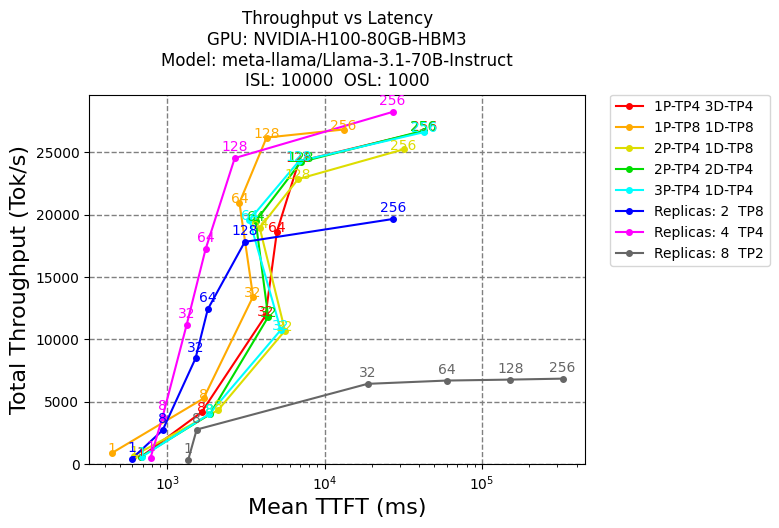

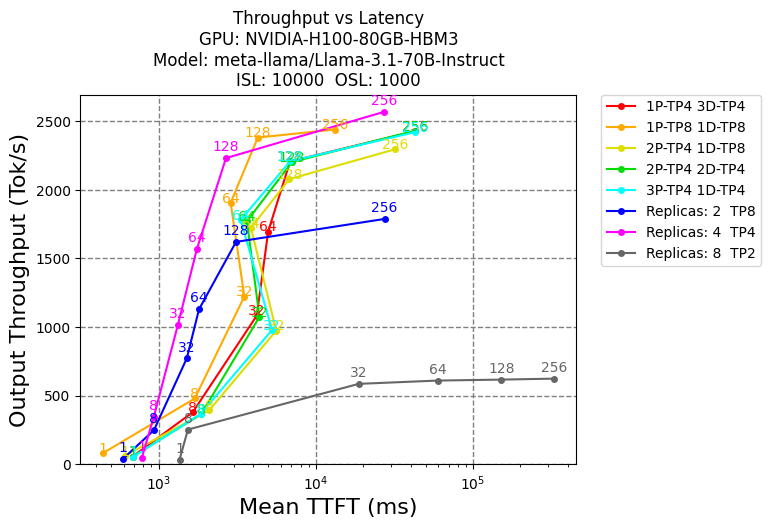

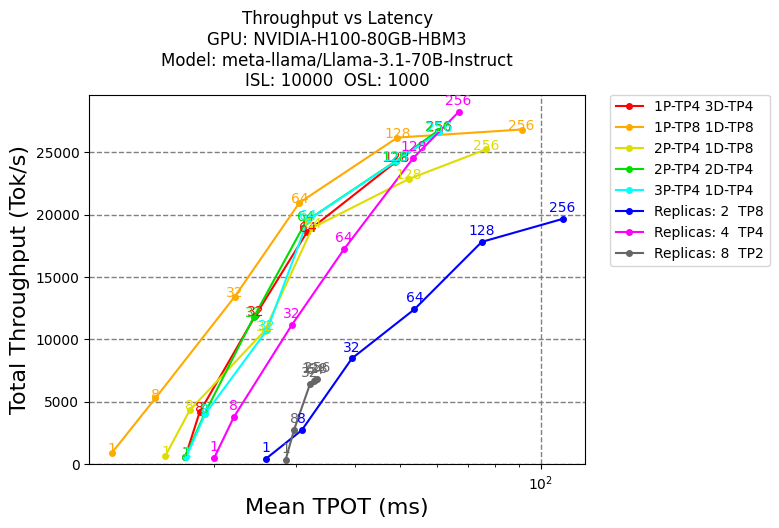

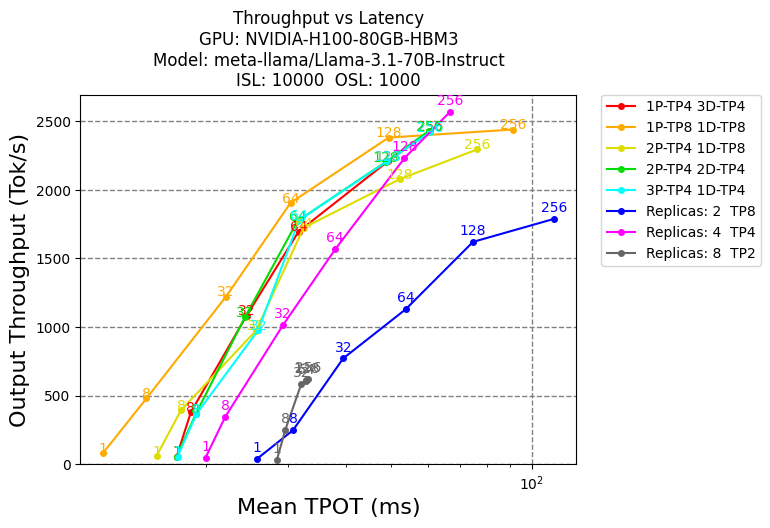

In [19]:
################################################################################
# User inputs
################################################################################

# Select scenario
idx = 0

# Show P/D disaggregated scenarios
show_pd = True
# Show standalone scenarios
show_sa = True

# Segregate traces by directory (directories with identical scenarios, such as
# repeated runs, will not be joined together in a single trace)
seg_by_dir = True

################################################################################
# Standard code
################################################################################

# Get parameters of selected scenario
model, gpu, isl, osl = scenarios[idx]

# Filter on column values
pd_runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Is_PD'] == True) ]

sa_runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Is_PD'] == False) ]

# Plot performance results
colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000',
         '#990000', '#777700', '#007700', '#009999', '#000099']

# Unique configurations of replicas and TP, described as a tuple
# Tuple format is (rep, tp, p_rep, p_tp, d_rep, d_tp, dir, is_pd)
config_sets = []
if seg_by_dir:
    configs_pd = list(set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP', 'Directory']).index))
    configs_sa = list(set(sa_runs_selected.set_index(['Replicas', 'TP', 'Directory']).index))
    if show_pd:
        for conf in configs_pd:
            config_sets.append((
                0,       # Replicas
                0,       # TP
                conf[0], # P replicas
                conf[1], # P TP
                conf[2], # D replicas
                conf[3], # D TP
                conf[4], # Directory
                True,    # Is PD
            ))
    if show_sa:
        for conf in configs_sa:
            config_sets.append((
                conf[0], # Replicas
                conf[1], # TP
                0,       # P replicas
                0,       # P TP
                0,       # D replicas
                0,       # D TP
                conf[2], # Directory
                False    # Is PD
            ))
else:
    pd_runs_selected = pd_runs_selected.drop('Directory', axis=1)
    sa_runs_selected = sa_runs_selected.drop('Directory', axis=1)
    configs_pd = list(set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']).index))
    configs_sa = list(set(sa_runs_selected.set_index(['Replicas', 'TP']).index))
    if show_pd:
        for conf in configs_pd:
            config_sets.append((
                0,       # Replicas
                0,       # TP
                conf[0], # P replicas
                conf[1], # P TP
                conf[2], # D replicas
                conf[3], # D TP
                0,       # Directory
                True,    # Is PD
            ))
    if show_sa:
        for conf in configs_sa:
            config_sets.append((
                conf[0], # Replicas
                conf[1], # TP
                0,       # P replicas
                0,       # P TP
                0,       # D replicas
                0,       # D TP
                0,       # Directory
                False    # Is PD
            ))

# Sort so prinouts/plots are organized
config_sets.sort()

# Convert the list of sets to a list of dicts, to make code following clearer
configs = []
for conf in config_sets:
    configs.append({
        'rep': conf[0],
        'tp': conf[1],
        'p_rep': conf[2],
        'p_tp': conf[3],
        'd_rep': conf[4],
        'd_tp': conf[5],
        'dir': conf[6],
        'is_pd': conf[7],
    })

if not configs:
    if show_pd:
        print('No P/D configurations for this scenario!')
    if show_sa:
        print('No standalone configurations for this scenario!')

################################################################################

# Plot total throughput vs TTFT
# Sweep through configurations
for ii, conf in enumerate(configs):
    is_pd = 'P_TP' in conf
    # Make a DataFrame for specific configuration
    if conf['is_pd']:
        # This configuration is PD
        if seg_by_dir:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp']) &
                (pd_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp'])
            ].sort_values(by='Concurrency')
    
        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TTFT_ms, conf_df.Total_Token_Throughput,
                 label=f'{conf['p_rep']}P-TP{conf['p_tp']} {conf['d_rep']}D-TP{conf['d_tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TTFT_ms)[jj],
                     list(conf_df.Total_Token_Throughput)[jj]+pd_runs_selected['Thpt_per_GPU'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    else:
        # This configuration is standalone
        if seg_by_dir:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp']) &
                (sa_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp'])
            ].sort_values(by='Concurrency')

        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TTFT_ms, conf_df.Total_Token_Throughput,
                 label=f'Replicas: {conf['rep']}  TP{conf['tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TTFT_ms)[jj],
                     list(conf_df.Total_Token_Throughput)[jj]+sa_runs_selected['Total_Token_Throughput'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])

if configs:
    plt.title(f'Throughput vs Latency\nGPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
    plt.xlabel('Mean TTFT (ms)', fontsize='16')
    plt.ylabel('Total Throughput (Tok/s)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([None, None, 0, None])
    plt.show()

################################################################################

# Plot output throughput vs TTFT
# Sweep through configurations
for ii, conf in enumerate(configs):
    is_pd = 'P_TP' in conf
    # Make a DataFrame for specific configuration
    if conf['is_pd']:
        # This configuration is PD
        if seg_by_dir:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp']) &
                (pd_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp'])
            ].sort_values(by='Concurrency')
    
        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TTFT_ms, conf_df.Output_Token_Throughput,
                 label=f'{conf['p_rep']}P-TP{conf['p_tp']} {conf['d_rep']}D-TP{conf['d_tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TTFT_ms)[jj],
                     list(conf_df.Output_Token_Throughput)[jj]+pd_runs_selected['Thpt_per_GPU'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    else:
        # This configuration is standalone
        if seg_by_dir:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp']) &
                (sa_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp'])
            ].sort_values(by='Concurrency')

        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TTFT_ms, conf_df.Output_Token_Throughput,
                 label=f'Replicas: {conf['rep']}  TP{conf['tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TTFT_ms)[jj],
                     list(conf_df.Output_Token_Throughput)[jj]+sa_runs_selected['Output_Token_Throughput'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])

if configs:
    plt.title(f'Throughput vs Latency\nGPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
    plt.xlabel('Mean TTFT (ms)', fontsize='16')
    plt.ylabel('Output Throughput (Tok/s)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([None, None, 0, None])
    plt.show()

################################################################################

# Plot total throughput vs TPOT
# Sweep through configurations
for ii, conf in enumerate(configs):
    is_pd = 'P_TP' in conf
    # Make a DataFrame for specific configuration
    if conf['is_pd']:
        # This configuration is PD
        if seg_by_dir:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp']) &
                (pd_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp'])
            ].sort_values(by='Concurrency')
    
        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TPOT_ms, conf_df.Total_Token_Throughput,
                 label=f'{conf['p_rep']}P-TP{conf['p_tp']} {conf['d_rep']}D-TP{conf['d_tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TPOT_ms)[jj],
                     list(conf_df.Total_Token_Throughput)[jj]+pd_runs_selected['Thpt_per_GPU'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    else:
        # This configuration is standalone
        if seg_by_dir:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp']) &
                (sa_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp'])
            ].sort_values(by='Concurrency')

        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TPOT_ms, conf_df.Total_Token_Throughput,
                 label=f'Replicas: {conf['rep']}  TP{conf['tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TPOT_ms)[jj],
                     list(conf_df.Total_Token_Throughput)[jj]+sa_runs_selected['Total_Token_Throughput'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])

if configs:
    plt.title(f'Throughput vs Latency\nGPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
    plt.xlabel('Mean TPOT (ms)', fontsize='16')
    plt.ylabel('Total Throughput (Tok/s)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([None, None, 0, None])
    plt.show()

################################################################################

# Plot output throughput vs TPOT
# Sweep through configurations
for ii, conf in enumerate(configs):
    is_pd = 'P_TP' in conf
    # Make a DataFrame for specific configuration
    if conf['is_pd']:
        # This configuration is PD
        if seg_by_dir:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp']) &
                (pd_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp'])
            ].sort_values(by='Concurrency')
    
        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TPOT_ms, conf_df.Output_Token_Throughput,
                 label=f'{conf['p_rep']}P-TP{conf['p_tp']} {conf['d_rep']}D-TP{conf['d_tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TPOT_ms)[jj],
                     list(conf_df.Output_Token_Throughput)[jj]+pd_runs_selected['Thpt_per_GPU'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    else:
        # This configuration is standalone
        if seg_by_dir:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp']) &
                (sa_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp'])
            ].sort_values(by='Concurrency')

        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TPOT_ms, conf_df.Output_Token_Throughput,
                 label=f'Replicas: {conf['rep']}  TP{conf['tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TPOT_ms)[jj],
                     list(conf_df.Output_Token_Throughput)[jj]+sa_runs_selected['Output_Token_Throughput'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])

if configs:
    plt.title(f'Throughput vs Latency\nGPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
    plt.xlabel('Mean TPOT (ms)', fontsize='16')
    plt.ylabel('Output Throughput (Tok/s)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([None, None, 0, None])
    plt.show()

## TPOT vs TTFT

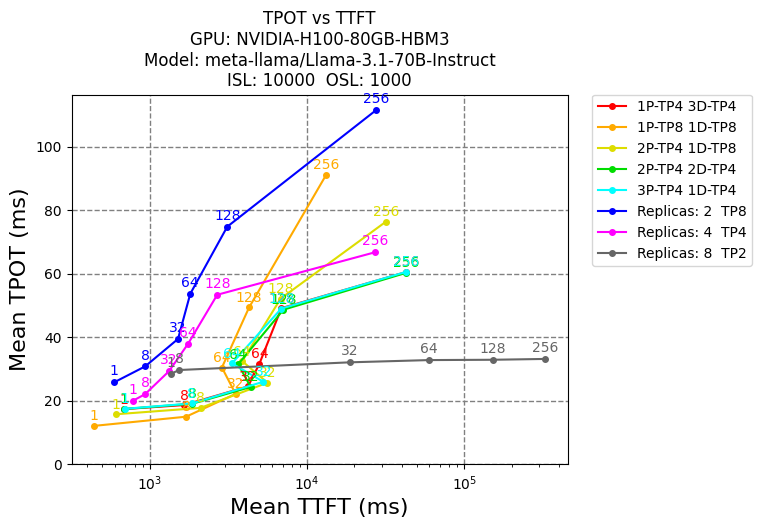

In [21]:
################################################################################
# User inputs
################################################################################

# Select scenario
idx = 0

# Show P/D disaggregated scenarios
show_pd = True
# Show standalone scenarios
show_sa = True

# Segregate traces by directory (directories with identical scenarios, such as
# repeated runs, will not be joined together in a single trace)
seg_by_dir = True

################################################################################
# Standard code
################################################################################

# Get parameters of selected scenario
model, gpu, isl, osl = scenarios[idx]

# Filter on column values
pd_runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Is_PD'] == True) ]

sa_runs_selected = runs[
    (runs['Model'] == model) &
    (runs['GPU'] == gpu) &
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Is_PD'] == False) ]

# Plot performance results
colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000',
         '#990000', '#777700', '#007700', '#009999', '#000099']

# Unique configurations of replicas and TP, described as a tuple
# Tuple format is (rep, tp, p_rep, p_tp, d_rep, d_tp, dir, is_pd)
config_sets = []
if seg_by_dir:
    configs_pd = list(set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP', 'Directory']).index))
    configs_sa = list(set(sa_runs_selected.set_index(['Replicas', 'TP', 'Directory']).index))
    if show_pd:
        for conf in configs_pd:
            config_sets.append((
                0,       # Replicas
                0,       # TP
                conf[0], # P replicas
                conf[1], # P TP
                conf[2], # D replicas
                conf[3], # D TP
                conf[4], # Directory
                True,    # Is PD
            ))
    if show_sa:
        for conf in configs_sa:
            config_sets.append((
                conf[0], # Replicas
                conf[1], # TP
                0,       # P replicas
                0,       # P TP
                0,       # D replicas
                0,       # D TP
                conf[2], # Directory
                False    # Is PD
            ))
else:
    pd_runs_selected = pd_runs_selected.drop('Directory', axis=1)
    sa_runs_selected = sa_runs_selected.drop('Directory', axis=1)
    configs_pd = list(set(pd_runs_selected.set_index(['P_Replicas', 'P_TP', 'D_Replicas', 'D_TP']).index))
    configs_sa = list(set(sa_runs_selected.set_index(['Replicas', 'TP']).index))
    if show_pd:
        for conf in configs_pd:
            config_sets.append((
                0,       # Replicas
                0,       # TP
                conf[0], # P replicas
                conf[1], # P TP
                conf[2], # D replicas
                conf[3], # D TP
                0,       # Directory
                True,    # Is PD
            ))
    if show_sa:
        for conf in configs_sa:
            config_sets.append((
                conf[0], # Replicas
                conf[1], # TP
                0,       # P replicas
                0,       # P TP
                0,       # D replicas
                0,       # D TP
                0,       # Directory
                False    # Is PD
            ))

# Sort so prinouts/plots are organized
config_sets.sort()

# Convert the list of sets to a list of dicts, to make code following clearer
configs = []
for conf in config_sets:
    configs.append({
        'rep': conf[0],
        'tp': conf[1],
        'p_rep': conf[2],
        'p_tp': conf[3],
        'd_rep': conf[4],
        'd_tp': conf[5],
        'dir': conf[6],
        'is_pd': conf[7],
    })

if not configs:
    if show_pd:
        print('No P/D configurations for this scenario!')
    if show_sa:
        print('No standalone configurations for this scenario!')

# Sweep through configurations
for ii, conf in enumerate(configs):
    is_pd = 'P_TP' in conf
    # Make a DataFrame for specific configuration
    if conf['is_pd']:
        # This configuration is PD
        if seg_by_dir:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp']) &
                (pd_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = pd_runs_selected[
                (pd_runs_selected['P_Replicas'] == conf['p_rep']) &
                (pd_runs_selected['P_TP'] == conf['p_tp']) &
                (pd_runs_selected['D_Replicas'] == conf['d_rep']) &
                (pd_runs_selected['D_TP'] == conf['d_tp'])
            ].sort_values(by='Concurrency')
    
        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TTFT_ms, conf_df.Mean_TPOT_ms,
                 label=f'{conf['p_rep']}P-TP{conf['p_tp']} {conf['d_rep']}D-TP{conf['d_tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TTFT_ms)[jj],
                     list(conf_df.Mean_TPOT_ms)[jj]+pd_runs_selected['Mean_TPOT_ms'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])
    else:
        # This configuration is standalone
        if seg_by_dir:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp']) &
                (sa_runs_selected['Directory'] == conf['dir'])
            ].drop('Directory', axis=1).sort_values(by='Concurrency')
        else:
            conf_df = sa_runs_selected[
                (sa_runs_selected['Replicas'] == conf['rep']) &
                (sa_runs_selected['TP'] == conf['tp'])
            ].sort_values(by='Concurrency')

        # Plot throughputs for configuration
        plt.semilogx(conf_df.Mean_TTFT_ms, conf_df.Mean_TPOT_ms,
                 label=f'Replicas: {conf['rep']}  TP{conf['tp']}',
                 marker='o', markersize=4,
                 color=colors[ii%len(colors)]
                )
        for jj, val in enumerate(conf_df.Concurrency):
            plt.text(list(conf_df.Mean_TTFT_ms)[jj],
                     list(conf_df.Mean_TPOT_ms)[jj]+sa_runs_selected['Mean_TPOT_ms'].max()*0.02,
                     str(val), ha='center', color=colors[ii%len(colors)])

if configs:
    plt.title(f'TPOT vs TTFT\nGPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
    plt.xlabel('Mean TTFT (ms)', fontsize='16')
    plt.ylabel('Mean TPOT (ms)', fontsize='16')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([None, None, 0, None])
    plt.show()